<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/Bert_FCNN/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
import kagglehub
import pandas as pd
import re
import os
import zipfile
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import h5py
from torch.utils.data import TensorDataset, DataLoader

In [17]:
dataset_dir = "./fake_news_dataset"

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# download the dataset
dataset_name = "emineyetm/fake-news-detection-datasets"
print(f"Downloading dataset: {dataset_name}")
os.system(f"kaggle datasets download -d {dataset_name} -p {dataset_dir}")

# Extract the dataset
zip_file = None
for file in os.listdir(dataset_dir):
    if file.endswith(".zip"):
        zip_file = os.path.join(dataset_dir, file)
        break

print(f"Extracting {zip_file}...")
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall(dataset_dir)

# Dynamically locate CSVs
fake_path, true_path = None, None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Fake.csv" in file:
            fake_path = os.path.join(root, file)
        if "True.csv" in file:
            true_path = os.path.join(root, file)

# Load datasets
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Add labels and combine datasets
fake_df['label'] = 0
true_df['label'] = 1
df = pd.concat([fake_df, true_df]).reset_index(drop=True)

df = df.sample(frac=1).reset_index(drop=True)

print("Combined Dataset Preview:")
print(df.head())
print("\nDataset statistics:")
print(df.describe())

Extracting ./fake_news_dataset/fake-news-detection-datasets.zip...
Combined Dataset Preview:
                                               title  \
0  China says made representations to North Korea...   
1  TPP countries consider amendments to stalled t...   
2  Argentine president calls Trump a 'very tough ...   
3   Sarah Huckabee Sanders Just Said The DUMBEST ...   
4  DETROIT: BIKERS SHOW UP In Big Numbers To Defe...   

                                                text       subject  \
0  BEIJING (Reuters) - China s foreign ministry s...     worldnews   
1  SYDNEY (Reuters) - The 11 countries committed ...     worldnews   
2  DAVOS, Switzerland (Reuters) - Argentine Presi...  politicsNews   
3  If you have been vacationing under a rock over...          News   
4  Leftist agitators showed up tonight at the ope...      politics   

                 date  label  
0  September 4, 2017       1  
1    August 29, 2017       1  
2   January 22, 2016       1  
3       July 10, 2017    

In [20]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [12]:
!git clone https://github.com/AnastasiaKazanas/ANN-Final-Project.git

fatal: destination path 'ANN-Final-Project' already exists and is not an empty directory.


In [19]:
file_path = '/content/ANN-Final-Project/Bert_embeding_datasets/FakeNewsDetection.h5'

with h5py.File(file_path, 'r') as f:
    labels = np.array(f['labels'])
    print("Labels loaded from HDF5 file:", labels)
    print("Unique labels:", np.unique(labels))

# Convert to PyTorch tensors
input_ids = torch.tensor(input_ids, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Split data
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=42)

# Create Tensor datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Labels loaded from HDF5 file: [nan nan nan ... nan nan nan]
Unique labels: [nan]


<ipython-input-19-d4b88e69d711>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.float32)


In [13]:
# FCNN
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model
input_size = input_ids.shape[1]
hidden_size = 100
num_classes = 2

model = FullyConnectedModel(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

IndexError: Target -9223372036854775808 is out of bounds.

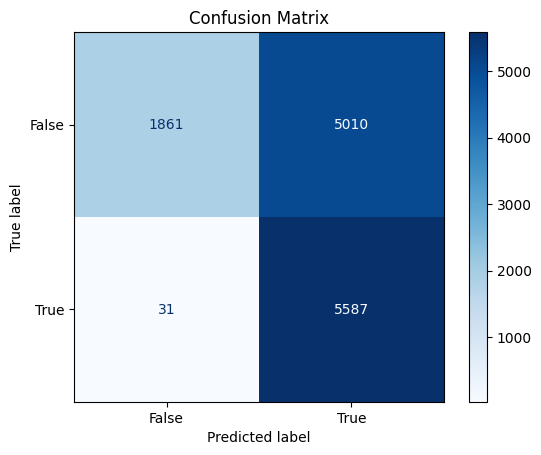

Accuracy of the model on the test data: 0.60


In [ ]:
model.eval()
all_preds = []
all_targets = []

correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.tolist())
        all_targets.extend(targets.tolist())

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy of the model on the test data: {accuracy:.2f}')
